In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
input_dir = 'input'
print(os.listdir(input_dir))

['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


In [4]:
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
import matplotlib.pyplot as plt
import imblearn #for SMOTE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split


In [5]:
# params = {'num_leaves': 491,
#           'min_child_weight': 0.03454472573214212,
#           'feature_fraction': 0.3797454081646243,
#           'bagging_fraction': 0.4181193142567742,
#           'min_data_in_leaf': 106,
#           'objective': 'binary',
#           'max_depth': 20,
#           'learning_rate': 0.006883242363721497,
#           "boosting_type": "gbdt",
#           "bagging_seed": 11,
#           "metric": 'auc',
#           "verbosity": -1,
#           'reg_alpha': 0.3899927210061127,
#           'reg_lambda': 0.6485237330340494,
#           'random_state': 47
#          }

In [6]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Wall time: 0 ns


In [61]:
%%time
def train_xgb(trainx,trainy):
    clf = xgb.XGBClassifier(n_estimators=500,
                        n_jobs=-1,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        missing=-999,
                        #tree_method='gpu_hist'
                        )

    clf.fit(trainx,trainy)
    return clf
from sklearn.linear_model import LogisticRegression

def train_lbg(trainx,trainy):
    params={'learning_rate': 0.01,
            'objective': 'binary',
            'metric': 'auc',
            'num_threads': -1,
            'num_leaves': 256,
            'verbose': 1,
            'random_state': 42,
            'bagging_fraction': 1,
            'feature_fraction': 0.85,
#             'is_unbalance':True
            'scale_pos_weight':6
           }
    clf = lgb.LGBMClassifier(**params,n_estimators=4000)
    clf.fit(trainx,trainy)
    return clf

def train_logistic(trainx,trainy):
    lr=LogisticRegression(max_iter=10000)
    lr.fit(X_train,y_train)
    return lr

Wall time: 0 ns


In [8]:
#Plotting
from sklearn.metrics import auc
def plot_pre_curve(y_validation,probs,title=''):
    precision, recall, thresholds = precision_recall_curve(y_validation, probs)
#     fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
    auc_pr = auc(recall,precision)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    plt.title(title+" precision recall curve "+str(auc_pr))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()
    
def plot_roc(y_validation,probs,title=''):
    fpr, tpr, thresholds = roc_curve(y_validation, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title(title+" ROC curve "+str(roc_auc_score(y_validation,probs)))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()
def feature_importance(model):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    sorted_idx = sorted_idx[len(feature_importance) - 50:]
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(10,12))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

In [9]:
from sklearn.model_selection import KFold, TimeSeriesSplit

def cross_validation_lgb(x,y):
    aucs = []
    for fold, (trn_idx, test_idx) in enumerate(TimeSeriesSplit(n_splits=5).split(x, y)):
        print('Training on fold {}'.format(fold + 1))
        trn_data = lgb.Dataset(x.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(x.iloc[test_idx], label=y.iloc[test_idx])
        clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
        aucs.append(clf.best_score['valid_1']['auc'])
    print('Training has finished.')
    print('Mean AUC:', np.mean(aucs))

def predict_plot(model):
    print(y_validation.shape,X_validation.shape)
    predictions =model.predict_proba(X_validation)[:,1]
    plot_pre_curve(y_validation,predictions,title='TEST ')
    plot_roc(y_validation,predictions,title='TEST ')

def predict_plot_train(model):
    predictions =model.predict_proba(X_train)[:,1]
    plot_pre_curve(y_train,predictions,title='TRAIN ')
    plot_roc(y_train,predictions,title='TRAIN ')
    feature_importance(model)


In [10]:
def label_encoding():
    # Label Encoding
    for f in test.columns:
        if train[f].dtype=='object' or test[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train[f].values) + list(test[f].values))
            train[f] = lbl.transform(list(train[f].values))
            test[f] = lbl.transform(list(test[f].values))   

In [11]:
import datetime
def engineer_dates(df):
    START_DATE = '2017-12-01'
    startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
    df['Date'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
    df['_weekday'] = df['Date'].dt.dayofweek
    df['_hour'] = df['Date'].dt.hour
    df['_day'] = df['Date'].dt.day

    df['_weekday'] = df['_weekday'].astype(str)
    df['_hour'] = df['_hour'].astype(str)
    df['_weekday__hour'] = df['_weekday'] + df['_hour']

    cnt_day = df['_day'].value_counts()
    cnt_day = cnt_day / cnt_day.mean()
    df['_count_rate'] = df['_day'].map(cnt_day.to_dict())

    df.drop(['TransactionDT','Date','_day'], axis=1, inplace=True)

In [12]:
def pca_vcols(all_data):
    vcols = [f'V{i}' for i in range(1,340)]
    sc = preprocessing.MinMaxScaler()
#     sc = preprocessing.StandardScaler()

    pca = PCA(n_components=2) #0.99
    vcol_pca = pca.fit_transform(sc.fit_transform(all_data[vcols].fillna(-1)))

    all_data['_vcol_pca0'] = vcol_pca[:,0]
    all_data['_vcol_pca1'] = vcol_pca[:,1]
    all_data['_vcol_nulls'] = all_data[vcols].isnull().sum(axis=1)

    all_data.drop(vcols, axis=1, inplace=True)


In [13]:
def extract_amount_features(all_data):
    import re
    #strong id features
    all_data['_P_emaildomain__addr1'] = all_data['P_emaildomain'].astype(str) + '__' + all_data['addr1'].astype(str)
    all_data['_card1__card2'] = all_data['card1'].astype(str) + '__' + all_data['card2'].astype(str)
    all_data['_card1__addr1'] = all_data['card1'].astype(str) + '__' + all_data['addr1'].astype(str)
    all_data['_card2__addr1'] = all_data['card2'].astype(str) + '__' + all_data['addr1'].astype(str)
    all_data['_card12__addr1'] = all_data['_card1__card2'] + '__' + all_data['addr1'].astype(str)
    all_data['_card_all__addr1'] = all_data['_card1__card2'] + '__' + all_data['addr1'].astype(str)
    
    #amount features
    all_data['_amount_decimal'] = ((all_data['TransactionAmt'] - all_data['TransactionAmt'].astype(int)) * 1000).astype(int)
    all_data['_amount_decimal_len'] = all_data['TransactionAmt'].apply(lambda x: len(re.sub('0+$', '', str(x)).split('.')[1]))
    all_data['_amount_fraction'] = all_data['TransactionAmt'].apply(lambda x: float('0.'+re.sub('^[0-9]|\.|0+$', '', str(x))))
    
    
    # statistics based on several features (how thery were chosen?? TODO)
    cols = ['ProductCD','card1','card2','card5','card6','P_emaildomain','_card_all__addr1']

    # amount mean&std
    for f in cols:
        all_data[f'_amount_mean_{f}'] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('mean')
        all_data[f'_amount_std_{f}'] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('std')
        all_data[f'_amount_pct_{f}'] = (all_data['TransactionAmt'] - all_data[f'_amount_mean_{f}']) / all_data[f'_amount_std_{f}']

    # freq encoding
    for f in cols:
        vc = all_data[f].value_counts(dropna=False)
        all_data[f'_count_{f}'] = all_data[f].map(vc)
    
    # handle object columns    
    cat_cols = [f'id_{i}' for i in range(12,39)]
    for i in cat_cols:
        if i in all_data.columns:
            all_data[i] = all_data[i].astype(str)
            all_data[i].fillna(-999, inplace=True)

    enc_cols = []
    for i, t in all_data.loc[:, all_data.columns != 'isFraud'].dtypes.iteritems():
        if t == object:
            enc_cols.append(i)
            #df = pd.concat([df, pd.get_dummies(df[i].astype(str), prefix=i)], axis=1)
            #df.drop(i, axis=1, inplace=True)
            all_data[i] = pd.factorize(all_data[i])[0]
            #all_data[i] = all_data[i].astype('category')
    all_data = all_data.replace([np.inf, -np.inf], np.nan)
    all_data = all_data.fillna(-999)

In [20]:
%%time
train_transaction = pd.read_csv(input_dir+'/train_transaction.csv', index_col='TransactionID')
# test_transaction = pd.read_csv(input_dir+'/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv(input_dir+'/train_identity.csv', index_col='TransactionID')
# test_identity = pd.read_csv(input_dir+'/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv(input_dir+'/sample_submission.csv', index_col='TransactionID')

Wall time: 16.1 s


In [21]:
# test_ids =test_transaction.index

In [22]:
%%time

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
# test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

train = train.fillna(-999)
# test = test.fillna('unknown')
# train = reduce_mem_usage2(train)

print(train.shape)

(590540, 433)
Wall time: 4.92 s


In [25]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.99]

# big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.98]

cols_to_drop = list(set(many_null_cols  + one_value_cols))
cols_to_drop = list(filter(lambda col: not col.startswith('V'),cols_to_drop))
print(cols_to_drop)
# cols_to_drop.remove('isFraud')
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)

[]
0 features are going to be dropped for being useless


In [26]:

# print(test.shape)
# label_encoding()

def feature_engineering(df):
    pca_vcols(df)
    engineer_dates(df)
    extract_amount_features(df)
    return df

train = feature_engineering(train)
# test = feature_engineering(test)

    
# Drop target, fill in NaNs
# X_train = train.drop('isFraud', axis=1)
# X_validation = test.copy()


In [27]:

y_train = train['isFraud'].copy()
X_train,X_validation,y_train,y_validation=train_test_split(train.drop('isFraud',axis=1),y_train,test_size=.2,random_state=1)

from imblearn.over_sampling import SMOTE
#ratio='minority'
smote = SMOTE(n_jobs=8,sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)
X_sm.shape,y_sm.shape,X_train.shape

X_train.columns

%%time
clf_lgb_smote = train_lbg(X_sm, y_sm)

#clf.predict_proba(X_validation)
predict_plot(clf_lgb_smote)
#predict_plot(clf)

In [59]:
%%time
clf_lgb = train_lbg(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Info] Number of positive: 16529, number of negative: 455903
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19130
[LightGBM] [Info] Number of data points in the t

(118108,) (118108, 136)


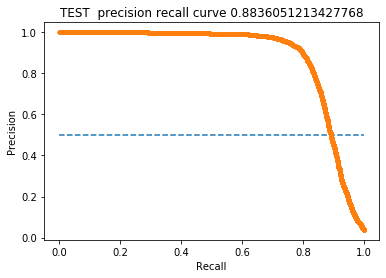

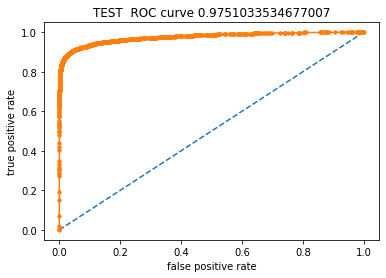

Wall time: 28 s


In [60]:
%%time
predict_plot(clf_lgb)

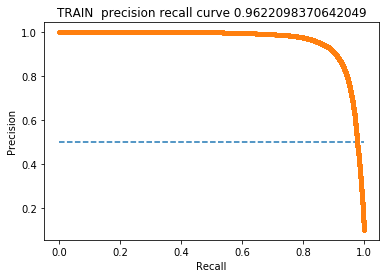

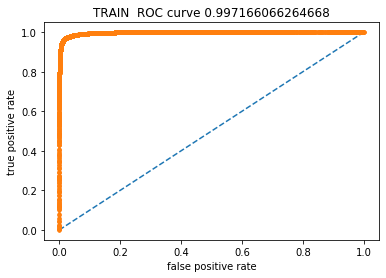

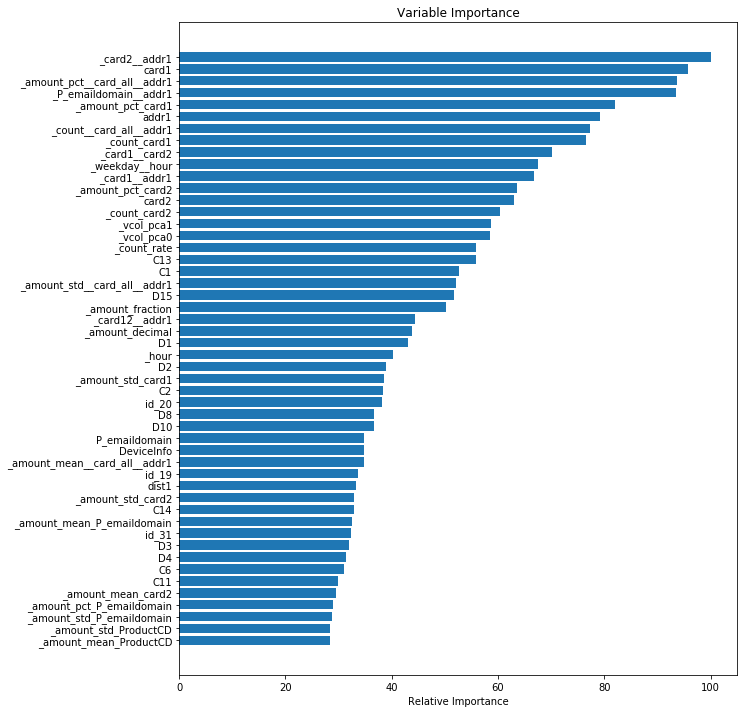

Wall time: 51.4 s


In [76]:
%%time
predict_plot_train(clf_lgb)

%%time
clf = train_xgb(X_train, y_train)
#clf = train_logistic(X_train,y_train)

predict_plot(clf)

%%time
clf_smote = train_xgb(X_sm,y_sm)

predict_plot(clf_smote)

In [ ]:
# sample_submission['isFraud'] = clf.predict_proba(X_validation)[:,1]
# sample_submission.to_csv('simple_xgboost.csv')

In [ ]:
# def train_and_evaluate(X_train,y_train,X_validation,y_validation):
#     clf = xgb.XGBClassifier(n_estimators=500,
#                         n_jobs=4,
#                         max_depth=9,
#                         learning_rate=0.05,
#                         subsample=0.9,
#                         colsample_bytree=0.9,
#                         missing=-999)

#     clf.fit(X_train, y_train)
#     print(y_validation.shape,X_validation.shape)
#     predictions =clf.predict(X_validation)
#     plot_pre_curve(y_validation,predictions)
#     plot_roc(y_validation,predictions)

In [ ]:
# def deleteStartingWith(df,prefix):
#     cols= df.loc[:, df.columns.str.startswith(prefix)]
#     del cols
#     del df[[col for col in df if col.startswith(prefix)]]
# deleteStartingWith(X_train,'M')
# deleteStartingWith(X_validation,'M')
# deleteStartingWith(X_train,'D')
# deleteStartingWith(X_validation,'D')

# del X_validation[[col for col in X_train if col.startswith('M')]]

In [ ]:
#submit!
def create_submission(model):
    test_preds = model.predict_proba(test)[:,1]
    submission = pd.DataFrame()
    pd.set_option('display.max_rows', 1000)
    pd.options.display.max_seq_items = 2000
    print(test.columns)
    submission['TransactionID'] = test.index
    submission['isFraud'] = test_preds
    submission.to_csv('submission.csv', index=False)

create_submission(clf_lgb)

In [ ]:
pred_ones = [1 for x in y_validation]
print(y_validation)
plot_roc(y_validation,pred_ones)
plot_pre_curve(y_validation,pred_ones)

In [ ]:
cross_validation_lgb(X_validation,y_validation)